# MinimumShareProduction

- Use `NemoMod MinimumShareProduction` to capture planned energy mix
- Note that there are some conflicting statements between sources:
    - 2023 IEA Energy transition plan says (p. 13): _Uganda would need to accelerate domestic end-use electrification efforts and greatly expand electricity exports to realise prior ambitions of installing 52 GW of generating capacity by 2040. These efforts could include earlier adoption of carbon capture, utilisation and storage (CCUS) and electrolytic hydrogen._
        - **NOTE** this is interpreted as _total capacity_ by 2040 as, on page 60, the report says: _The Energy Policy for Uganda 2023 states that by 2040 the country aims to have around 52 GW of installed capacity, which at healthy levels of utilisation would generate about 240 TWh annually_
- However, the Vision 2040 document states (list formatting added):
    - _The required capacity will be generated from different energy sources, namely_:
        - _hydro power (4500MW)_
        - _geo-thermal (1500 MW)_
        - _nuclear (24000 MW)_
        - _solar (5000 MW)_
        - _biomass (1700 MW)_
        - _peat (800 MW)_
        - _thermal (4300)_
    - Note that this totals 41.8 GW, ≈ 10.2 GW less than the ETP
- Additionally, installed capacity can guide production share, but it cannot define it

      

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.utilities._toolbox as sf
import utils.common_data_needs as cdn
import warnings
warnings.filterwarnings("ignore")

from typing import *

plt.style.use("dark_background", )



/opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/sisepuede/core/model_attributes.py:6684: UserWarning: 

                        MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution 
                        implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() 
                        to ensure that transition probability rows are enforced on a simplex.
                        
                        
                        FIX THIS ASAP TO DERIVE PROPERLY.
                        
                        
  warnings.warn(
/opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/sisepuede/utilities/_toolbox.py:2551: UserWarning: Warning passed from optional_log: Successfully archived self.model_attributes to pickle at '/opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-07-14T19;11;14.011803/sisepuede_run_2025-07-14T19;11;14.011803_model_attributes.pkl'.
  warnings.warn(f"Warning passed from optio

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1198.4 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
/opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/sisepuede/utilities/_toolbox.py:2551: UserWarning: Warning passed from optional_log: Successfully initialized JuMP optimizer from solver module HiGHS..
  warnings.warn(f"Warning passed from optional_log: {msg}.")


In [2]:
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")


# SET SOME GLOBALS

# uganda data frame
df_uganda = cdn.get_raw_ssp_inputs()


# set some energy categories
_CAT_ENTC_BIOMASS = "pp_biomass"
_CAT_ENTC_GEO = "pp_geothermal"
_CAT_ENTC_HYD = "pp_hydropower"
_CAT_ENTC_NUC = "pp_nuclear"
_CAT_ENTC_OIL = "pp_oil"
_CAT_ENTC_SOLAR = "pp_solar"
_CAT_ENTC_WIND = "pp_wind"


# fields

# year to build estimates out to
_YEAR_TARGET = 2100

# Load data we'll work with

- See Figure 2.22 for projections of production share in 2030, 2040, and 2050
![Figure 2.22](./input_data/iea_etp/fig_2_22_electricity_production_shares_projected.png)

## Using a graphic comparison, estimate fractions





<Axes: xlabel='year'>

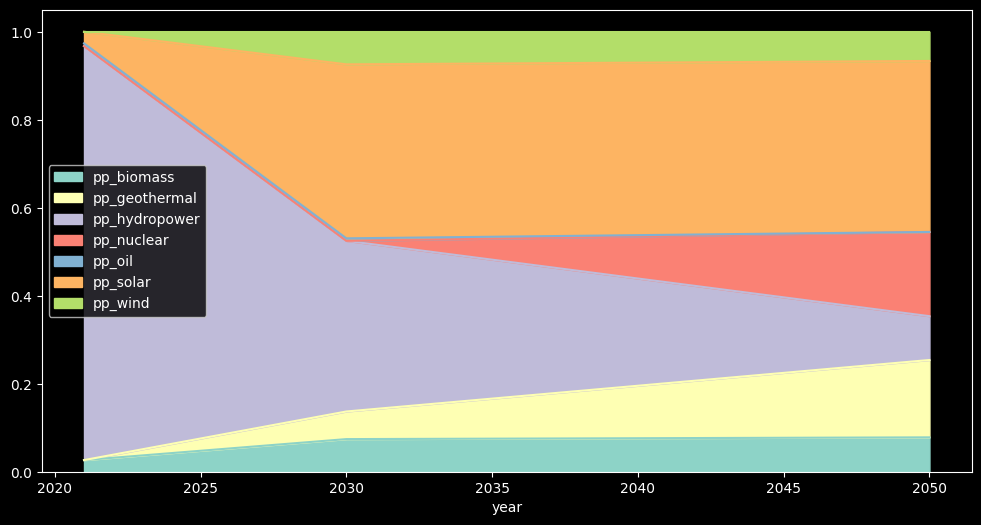

In [39]:

# weights were estimated using pixels
df_fracs = {
    time_periods.field_year: [2021, 2030, 2050],
    _CAT_ENTC_BIOMASS: [13, 39, 40],
    _CAT_ENTC_GEO: [0, 33, 90],
    _CAT_ENTC_HYD: [463, 204, 51],
    _CAT_ENTC_NUC: [0, 0, 98],
    _CAT_ENTC_OIL: [3, 3, 0],
    _CAT_ENTC_SOLAR: [13, 208, 199],
    _CAT_ENTC_WIND: [0, 39, 34],
}

df_fracs = pd.DataFrame(df_fracs, )


# normalize
fields_cats_entc = [x for x in df_fracs.keys() if x != time_periods.field_year]
arr = df_fracs[fields_cats_entc].to_numpy()
df_fracs[fields_cats_entc] = (arr.transpose()/arr.sum(axis = 1)).transpose()

fig, ax = plt.subplots(figsize = (12, 6))
df_fracs.plot.area(x = time_periods.field_year, ax = ax)

## Nose validation plot
- Compare roughyl to left panel

<Axes: xlabel='year'>

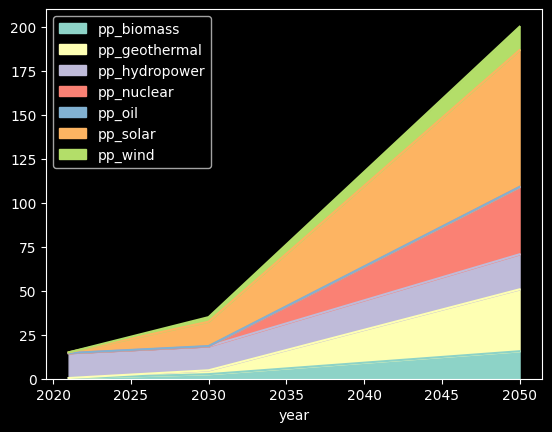

In [36]:
vec_totals = np.array([15, 35, 200])
df_fracs_plot = df_fracs.copy()
arr = df_fracs_plot[fields_cats_entc].to_numpy()
df_fracs_plot[fields_cats_entc] = (arr.transpose()*vec_totals).transpose()

df_fracs_plot.plot.area(x = "year")

# Get all years, merge, interpolate, and add "weights"
- After 2050, we have no information
- We reduce the MSP using 

In [54]:
df_years = cdn.spawn_years_space_df((2015, _YEAR_TARGET))

df_fracs_full = (
    pd.merge(
        df_years,
        df_fracs,
        how = "left",
    )
    .interpolate()
)




In [17]:
modvar_msp = matt.get_variable("NemoMod MinShareProduction")
df_tmp = modvar_msp.get_from_dataframe(
    df_uganda, 
    fields_additional = [time_periods.field_year]
)

df_tmp[[x for x in df_tmp.columns if df_tmp[x].min() > 0]]

,year,nemomod_entc_frac_min_share_production_pp_hydropower,nemomod_entc_frac_min_share_production_pp_oil,nemomod_entc_frac_min_share_production_pp_solar
0,2015,0.860323,0.032554,0.008904
1,2016,0.865113,0.029597,0.010215
2,2017,0.901519,0.028549,0.015977
3,2018,0.846709,0.072110,0.016283
4,2019,0.884093,0.030456,0.026074
5,2020,0.889664,0.025949,0.027911
6,2021,0.879788,0.024080,0.026545
7,2022,0.861967,0.026152,0.025286
8,2023,0.861967,0.026152,0.025286
9,2024,0.861967,0.026152,0.025286


In [16]:
df_tmp.iloc[0]



nemomod_entc_frac_min_share_production_fp_hydrogen_electrolysis       0.000000
nemomod_entc_frac_min_share_production_fp_hydrogen_gasification       0.000000
nemomod_entc_frac_min_share_production_fp_hydrogen_reformation        0.000000
nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs    0.000000
nemomod_entc_frac_min_share_production_pp_biogas                      0.000000
nemomod_entc_frac_min_share_production_pp_biomass                     0.000000
nemomod_entc_frac_min_share_production_pp_coal                        0.000000
nemomod_entc_frac_min_share_production_pp_coal_ccs                    0.000000
nemomod_entc_frac_min_share_production_pp_gas                         0.000000
nemomod_entc_frac_min_share_production_pp_gas_ccs                     0.000000
nemomod_entc_frac_min_share_production_pp_geothermal                  0.000000
nemomod_entc_frac_min_share_production_pp_hydropower                  0.860323
nemomod_entc_frac_min_share_production_pp_nuclear   

In [165]:
df_transmission_loss = (
    pd.concat(
        [df_loss, df_proj],
        axis = 0,
    )
    .sort_values(by = [time_periods.field_year], )
    .reset_index(drop = True, )
)

df_transmission_loss.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_tlf.name_fs_safe.upper()}.csv"),
    encoding = "UTF-8",
    index = None,
)